We approximate village clusters by running DBSCAN on the 34 x 34 grid (of 300m x 300m tiles, to make a 10200m x 10200m region) containing several boxes, and in particular box centers.

Boxes are labeled by sq number and then by an arbitrary index.

In [1]:
import numpy as np
import pickle
import sys
from PIL import Image
import cv2
from glob import glob

from hyper import 

In [2]:
IMG_ID = 21430002

def box_name(sq, qrt):
    return "boxes/dg_lsms_uganda_1000x1000_" + str(IMG_ID) + "_" + \
    str(sq) + "_" + str(qrt) + ".pickle"

In [3]:
# the sq-1 is because sq is in range [1, 1156]

def get_y(sq, qrt, y):
    return 1000 * ((sq-1) % 34) + 500 * (qrt % 2) + y

def get_x(sq, qrt, x):
    return 1000 * int((sq-1) / 34) + 500 * int(qrt / 2) + x

In [4]:
NUM_SQ = 1156
HOUSE_SIZE_THRESH = 8000.
X = np.zeros([1, 2])  # don't forget to remove this at the end

for sq in range(1, NUM_SQ+1):  # update to len(val_files)
    for qrt in range(4):
        pickle_in = open(box_name(sq, qrt), "rb")
        boxes = pickle.load(pickle_in)
        
        if boxes is not None:   # boxes exist in this tile
            for box in boxes:
                # size = (box.xmax - box.xmin) * (box.ymax - box.ymin)
                # if size > HOUSE_SIZE_THRESH: continue
                
                temp = np.zeros([1, 2])
                x = np.mean([box.xmin, box.xmax])
                y = np.mean([box.ymin, box.ymax])
                
                temp[0, 0] = get_x(sq, qrt, x)
                temp[0, 1] = get_y(sq, qrt, y)
                X = np.concatenate((X, temp))
            
            
X = np.delete(X, (0), axis=0)  # didn't forget :)

In [5]:
metrics = {}
metrics['num_houses'] = X.shape[0]
print("Total number of houses =", metrics['num_houses'])

Total number of houses = 8079


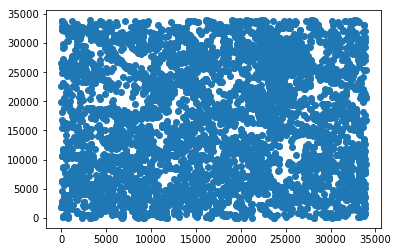

In [6]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1])
plt.show()

# DBSCAN Clustering

In [7]:
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

dist_max = 80 # meters

db = cluster.DBSCAN(eps=dist_max / 0.3, min_samples=4)
db.fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

https://en.wikipedia.org/wiki/Silhouette_(clustering)

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object lies within its cluster.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

In [8]:
print('Estimated number of clusters: %d' % n_clusters_)
# print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 549


In [9]:
# Plot result
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]

def display(X, labels, core_samples_mask):
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    # print("unique labels = ", unique_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    # print(colors)
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=8)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

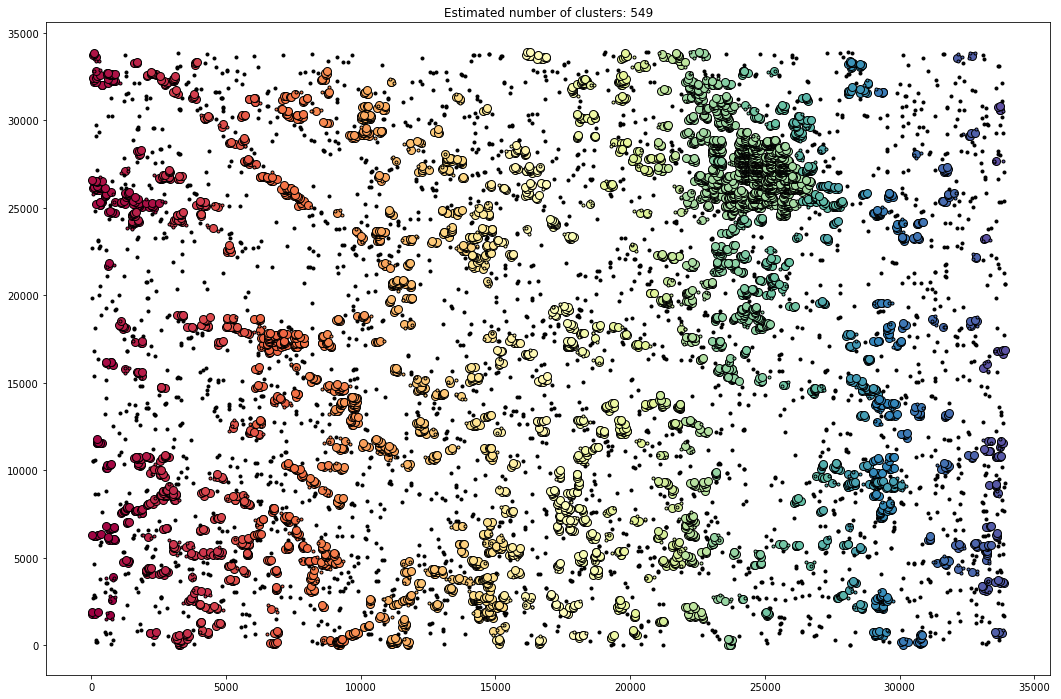

In [10]:
display(X, labels, core_samples_mask)

In [11]:
X_dnsd = X[labels >= 0]
csm_dnsd = core_samples_mask[labels >= 0]
labels_dnsd = labels[labels >= 0]
print("Number of denoised =", X_dnsd.shape[0])

# labels_tops_mask = labels_dnsd

Number of denoised = 5807


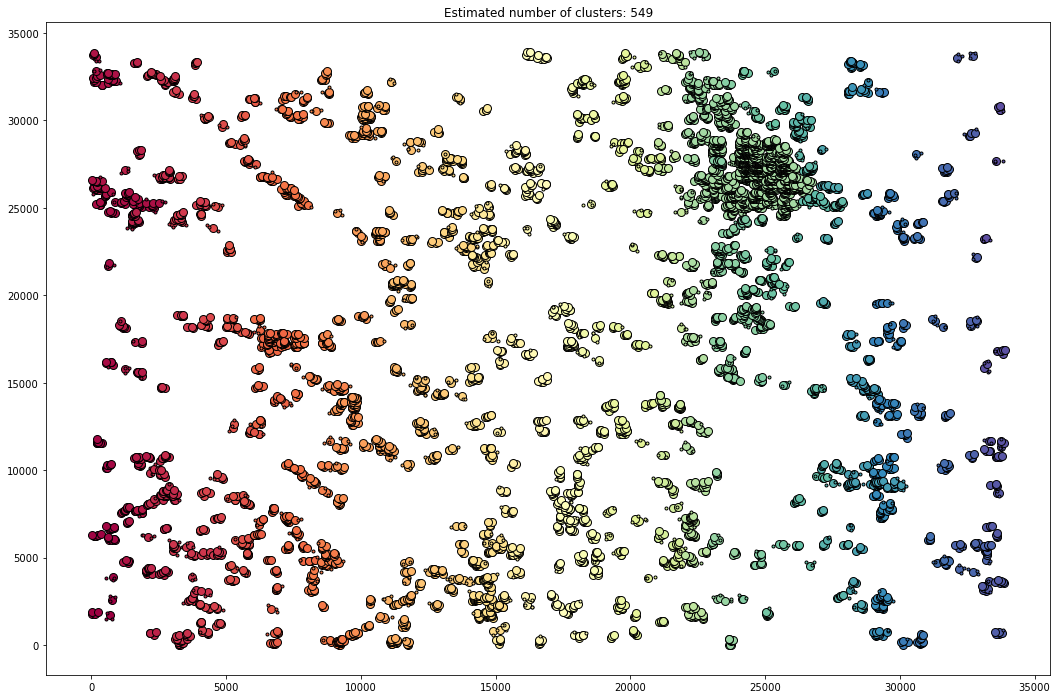

In [12]:
display(X_dnsd, labels_dnsd, csm_dnsd)

In [13]:
def surrounding_tiles(n, k=3):
    tiles = []
    low =  int(-(k-1)/2)
    high = int((k+1)/2)
    
    for i in range(low, high):  # rows
        row = []
        
        for j in range(low, high):  # columns
            y = n%34 if (n%34 > 0) else 34  # 1 to 34
            x = int(n / 34)                 # 0 to 33
            
            if (0 <= x+j <= 33) and (1 <= y+i <= 34):
                tile = 34*(x+j) + (y+i)
                row.append(tile)
            else:
                row.append(-1)

        tiles.append(row)
                
    return tiles

In [14]:
def stitch_tiles(n, k=3, boxed=True):
    all_tiles = surrounding_tiles(n, k)
    # print("stitching:", all_tiles)
    
    imgs = []
    for r in range(k):
        row = all_tiles[r]
        temp = []
        
        for c in range(k):
            if row[c] == -1:
                temp.append(cv2.imread('empty.jpeg'))
            else:
                if not boxed:
                    fname = 'LSMS_dg/dg_lsms_uganda_1000x1000_' + str(IMG_ID) + '_' + str(row[c]) + '.jpeg'
                    temp.append(cv2.imread(fname))
                
                
                '''
                else:
                    quart_names = 'box_imgs/dg_lsms_uganda_1000x1000_' + str(IMG_ID) + '_' + str(row[c]) + '_*.jpeg'
                    quart = [cv2.imread(im) for im in sorted(glob(quart_names))]
                    connect_four = np.concatenate([np.concatenate([quart[0], quart[1]], axis=1),
                                                   np.concatenate([quart[2], quart[3]], axis=1)], axis=0)
                    temp.append(connect_four)
                '''

        row_cat = np.concatenate(temp, axis=1)
        imgs.append(row_cat)
    
    return np.concatenate(imgs, axis=0)

In [15]:
'''
(values,counts) = np.unique(labels_dnsd,return_counts=True)
ind = np.argmax(counts)
print("Most populated village =", values[ind])

x, y = np.mean(X_dnsd[labels_dnsd == values[ind]], axis=0)
print("x = %.2f, y = %.2f" % (x, y))

main_sq = int(y / 1000)+1 + 34*int(x / 1000)
print(main_sq)
'''

'\n(values,counts) = np.unique(labels_dnsd,return_counts=True)\nind = np.argmax(counts)\nprint("Most populated village =", values[ind])\n\nx, y = np.mean(X_dnsd[labels_dnsd == values[ind]], axis=0)\nprint("x = %.2f, y = %.2f" % (x, y))\n\nmain_sq = int(y / 1000)+1 + 34*int(x / 1000)\nprint(main_sq)\n'

In [16]:
def most_populated(r=5):
    (values,counts) = np.unique(labels_dnsd,return_counts=True)
    arg = counts.argsort()[-r:][::-1]
    
    for idx in range(r):
        print("%s-th most populated village is %s with a house count of %s" % (idx+1, values[arg[idx]], counts[arg[idx]]))
        
        x, y = np.mean(X_dnsd[labels_dnsd == values[arg[idx]]], axis=0)
        print("x = %.2f, y = %.2f" % (x, y))
        main_sq = int(y / 1000)+1 + 34*int(x / 1000)
        print("main square = %s" % main_sq)
        print()
        
        stitched = Image.fromarray(stitch_tiles(main_sq, k=3, boxed=True))
        stitched.save("outputs/dg_lsms_uganda_1000x1000_%s_%s_tops-%s.jpeg" % (IMG_ID, main_sq, idx+1))

In [17]:
most_populated(20)

1-th most populated village is 387 with a house count of 987
x = 24749.64, y = 26908.64
main square = 843

2-th most populated village is 393 with a house count of 71
x = 23419.94, y = 30450.03
main square = 813

3-th most populated village is 389 with a house count of 69
x = 23075.48, y = 28565.55
main square = 811

4-th most populated village is 407 with a house count of 61
x = 24518.42, y = 18760.21
main square = 835

5-th most populated village is 103 with a house count of 60
x = 6764.73, y = 17410.09
main square = 222

6-th most populated village is 394 with a house count of 46
x = 22373.07, y = 31750.50
main square = 780

7-th most populated village is 13 with a house count of 41
x = 1702.20, y = 25355.57
main square = 60

8-th most populated village is 218 with a house count of 40
x = 14603.88, y = 2542.56
main square = 479

9-th most populated village is 445 with a house count of 38
x = 27154.50, y = 25330.52
main square = 944

10-th most populated village is 37 with a house co

In [18]:
(values,counts) = np.unique(labels_dnsd,return_counts=True)
tops = counts.argsort()[-20:][::-1]
print(tops)

[387 393 389 407 103 394  13 218 445  37 471 408 116  17 155 124 180 370
 474 233]


In [19]:
# terrible loopy way of doing this, but python was complaining about the other reasonable approaches soooo

X_tops = np.zeros([1, 2])

labels_tops = []
csm_tops = []
for _ in range(len(labels_dnsd)):
    if labels_dnsd[_] in tops:
        temp = X_dnsd[_].reshape((1, 2))
        X_tops = np.concatenate((X_tops, temp))
        labels_tops.append(labels_dnsd[_])
        csm_tops.append(csm_dnsd[_])
        
X_tops = np.delete(X_tops, (0), axis=0)  # didn't forget :)
labels_tops = np.array(labels_tops)
csm_tops = np.array(csm_tops)

labels_tops_mask = 

X_tops = X_dnsd[labels_tops_mask > 0]
csm_tops = csm_dnsd[labels_tops_mask > 0]
labels_tops = labels_dnsd[labels_tops_mask > 0]
print("Total number of tops-homes =", X_tops.shape[0])

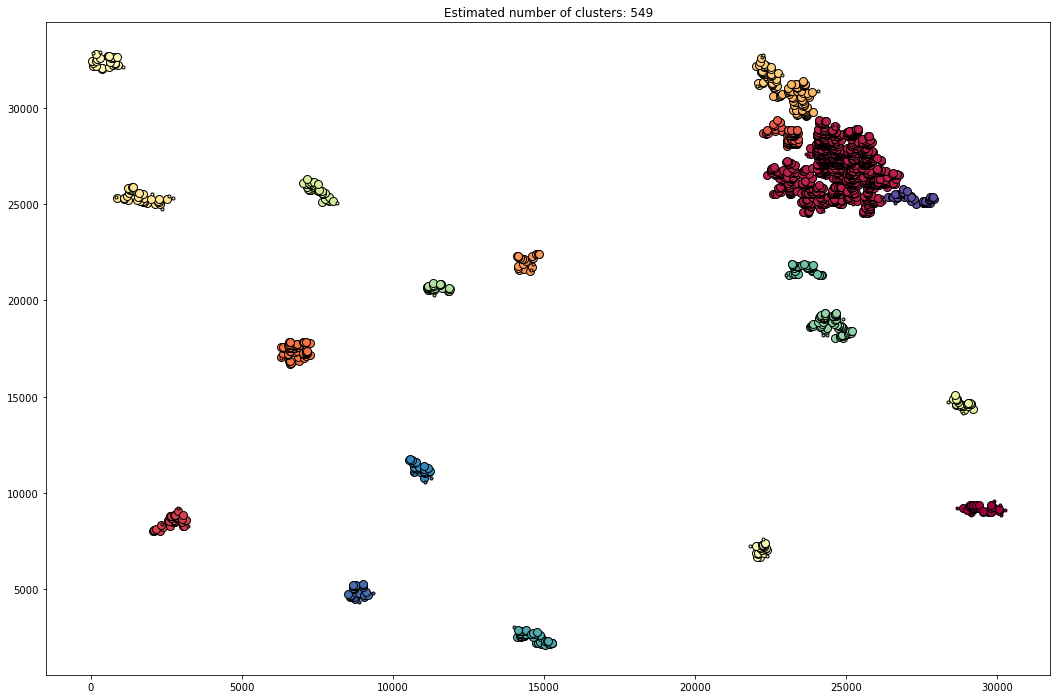

In [20]:
display(X_tops, labels_tops, csm_tops)